In [107]:
#### Cut one box
import cv2
from ultralytics import YOLO

# weight_model = "/Users/YaVolkonskiy/Documents/Projects/tomato/scripts/002_train_tomato_det_seg/tomato_det_seg.pt"
weight_model = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/002_data_experiments/002_train_leaf_tomato/best_leaf.pt"

# img_path="/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/imgs/GX010046_001.png"
img_path="/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/GO_PRO_SBER_20231101_ALL/out_image/GX010039/GX010039_13.jpg"

frame = cv2.imread(img_path)

model = YOLO(weight_model)
results=model(frame, imgsz= 2688,conf=0.5)



0: 1536x2688 299 leafs, 1 stem, 2566.5ms
Speed: 24.2ms preprocess, 2566.5ms inference, 861.5ms postprocess per image at shape (1, 3, 1536, 2688)


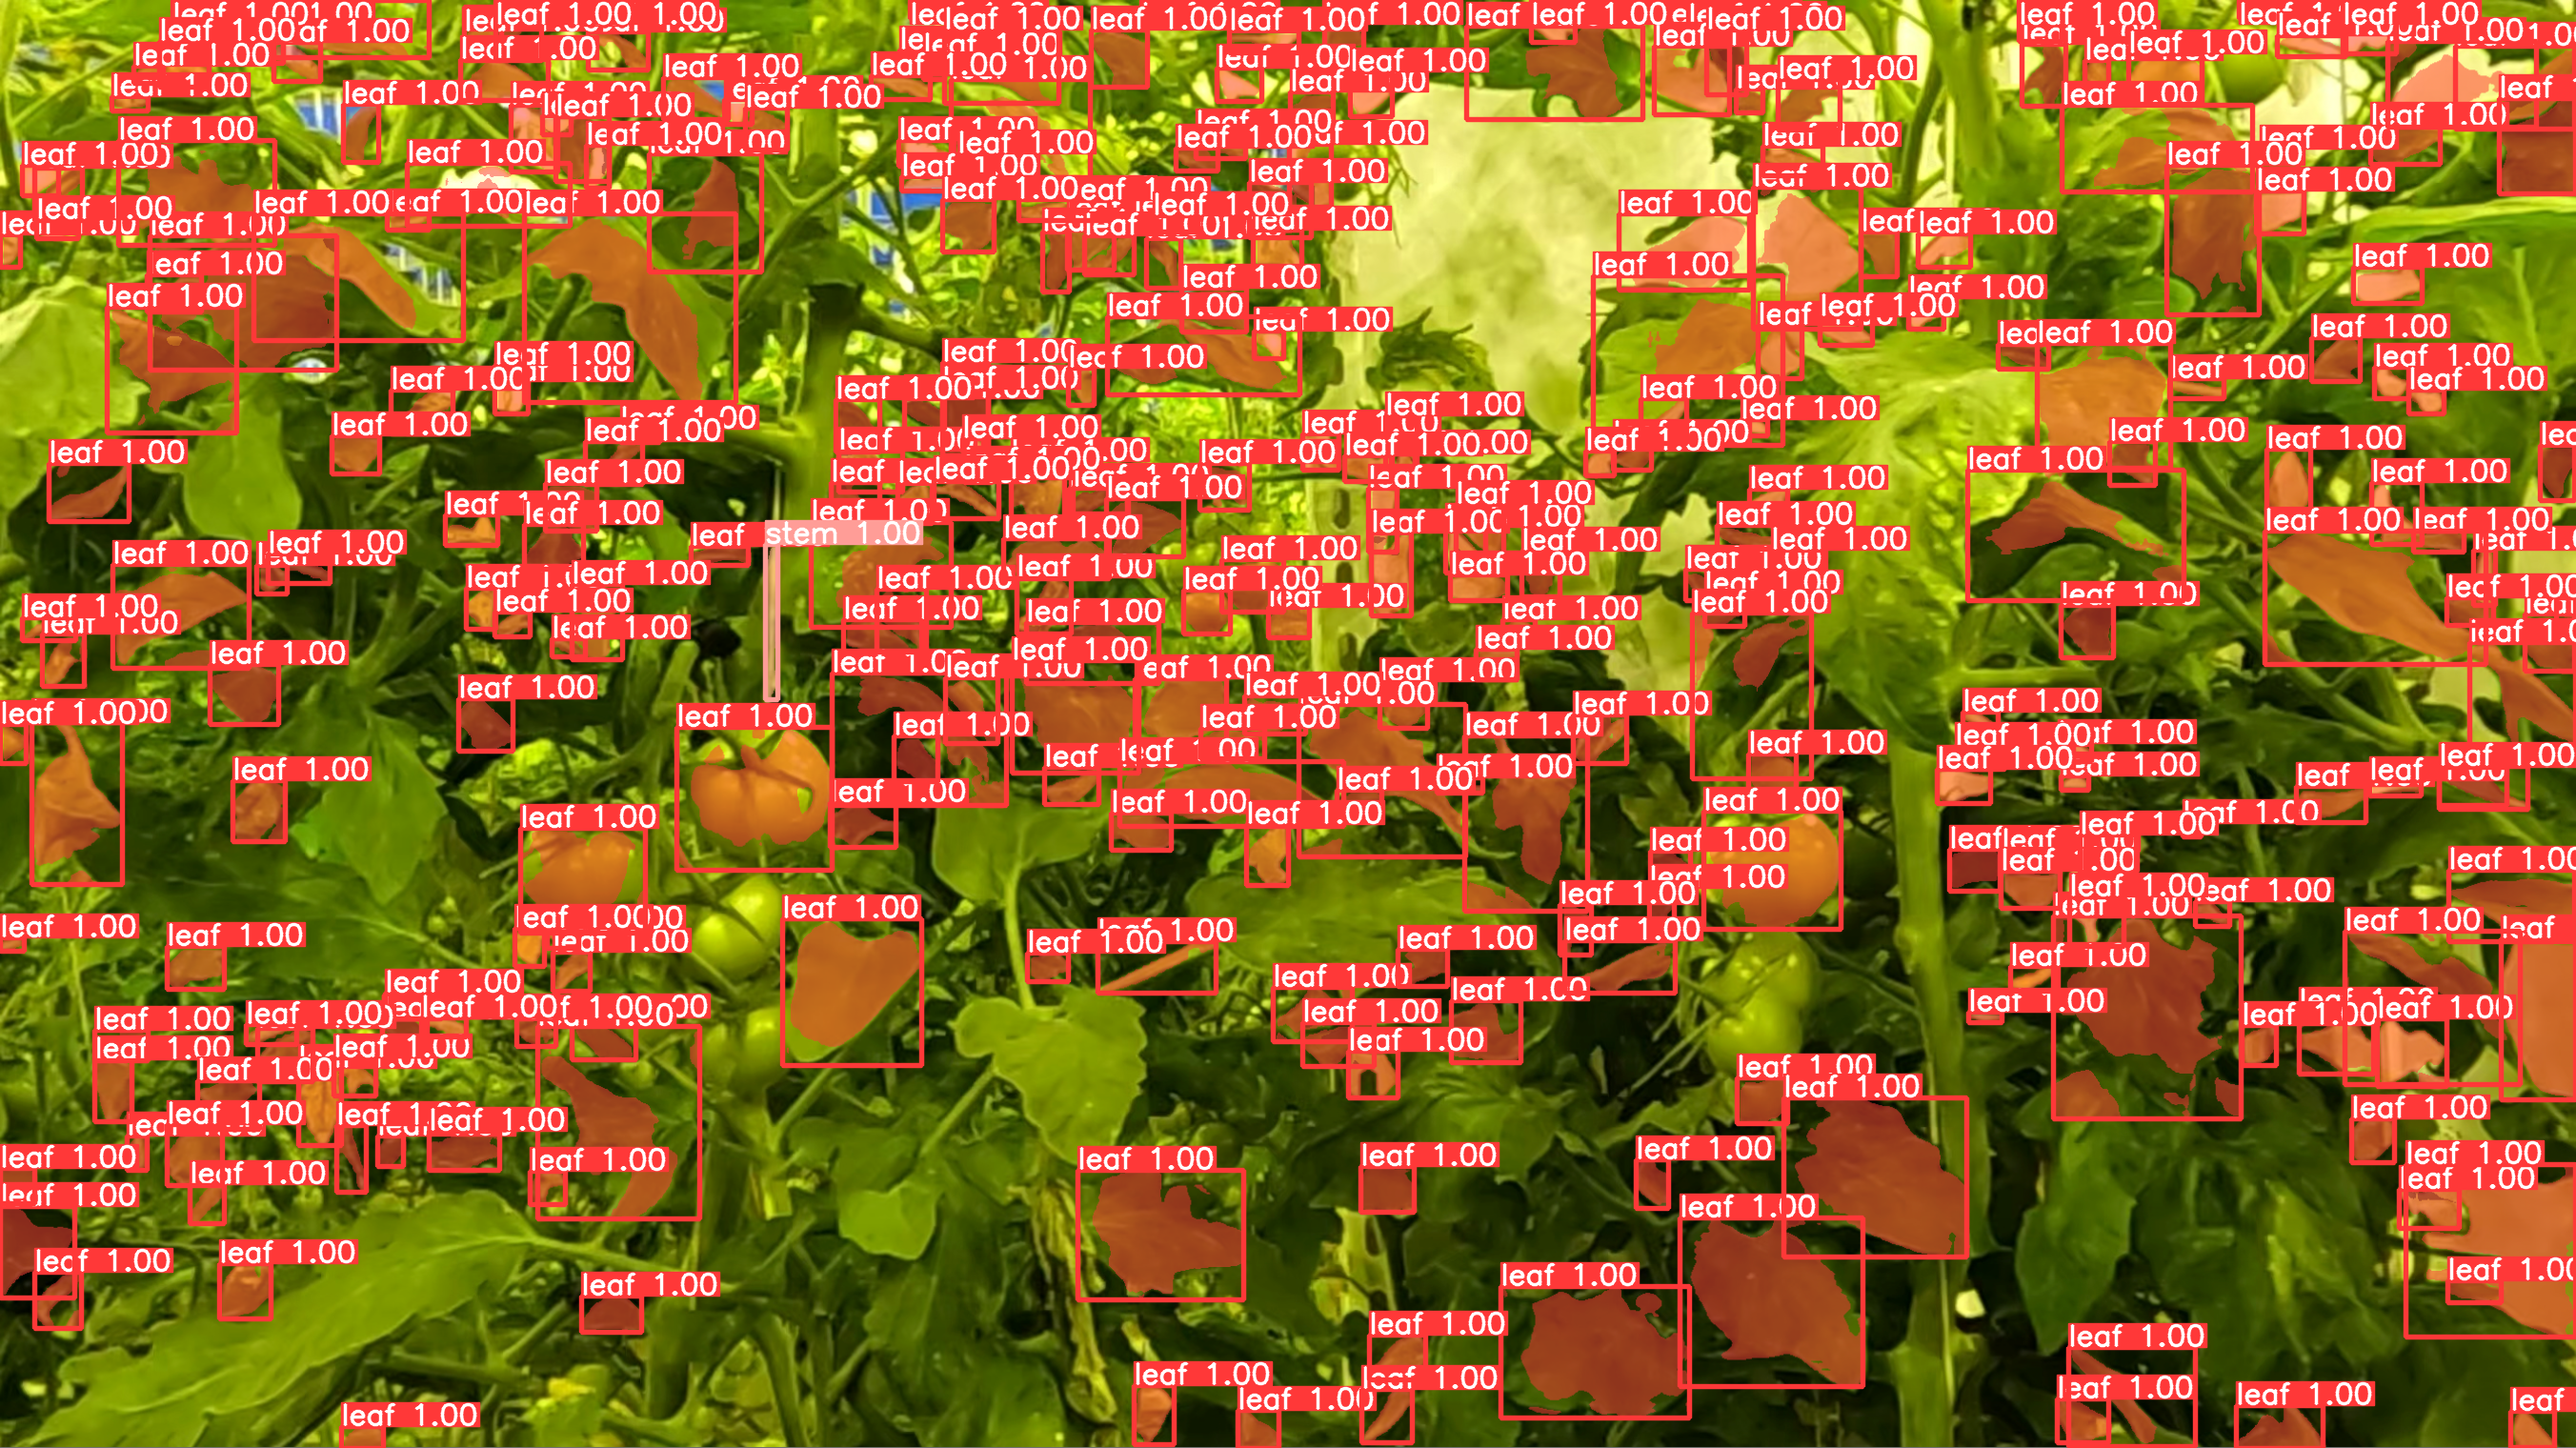

In [108]:
from PIL import Image

im_array = results[0].plot(line_width=3, font_size = 10 )  # plot a BGR numpy array of predictions
pil_img = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(pil_img)

In [85]:
len(results[0].boxes.cls)

300

In [32]:
results[0]#.boxes

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'b_fully_ripened', 1: 'b_green', 2: 'b_half_ripened', 3: 'l_fully_ripened', 4: 'l_green', 5: 'l_half_ripened'}
orig_img: array([[[  9, 167, 116],
        [  5, 164, 112],
        [  0, 153, 102],
        ...,
        [  8, 165, 132],
        [  6, 164, 131],
        [  5, 162, 130]],

       [[ 10, 168, 117],
        [  5, 164, 112],
        [  0, 157, 105],
        ...,
        [ 11, 168, 136],
        [ 10, 167, 134],
        [  6, 164, 131]],

       [[  9, 166, 117],
        [  5, 162, 113],
        [  0, 157, 108],
        ...,
        [ 22, 180, 147],
        [ 19, 176, 144],
        [ 17, 174, 141]],

       ...,

       [[  0, 176, 103],
        [  0, 178, 104],
        [  0, 178, 104],
        ...,
        [  0, 137,  53],
        [  0, 131,  46],
        [  0, 126,  41]],

       [[  0, 255,   0],


In [23]:
results[0].masks.data.shape

torch.Size([53, 384, 640])

In [19]:
masks

NoneType

In [34]:
result=results[0]

result.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 4., 1., 1., 1., 1., 1., 4., 1., 1., 4., 1., 1., 4., 1., 4., 4., 4., 1., 1., 1., 4., 1., 1., 4., 4., 1., 4., 4., 4., 1., 1., 1., 4., 1., 4., 1., 1., 4., 4., 1., 4., 4., 1., 4.])
conf: tensor([0.9390, 0.9366, 0.9326, 0.9276, 0.9219, 0.9177, 0.9169, 0.9008, 0.8935, 0.8776, 0.8734, 0.8715, 0.8597, 0.8583, 0.8441, 0.8419, 0.8281, 0.8197, 0.8173, 0.8061, 0.7969, 0.7921, 0.7780, 0.7746, 0.7711, 0.7418, 0.7381, 0.7245, 0.7184, 0.7053, 0.6942, 0.6939, 0.6937, 0.6868, 0.6815, 0.6675, 0.6659, 0.6569, 0.6179,
        0.6163, 0.6114, 0.6047, 0.5770, 0.5758, 0.5701, 0.5603, 0.5525, 0.5339, 0.5328, 0.5232, 0.5185, 0.5107, 0.5075])
data: tensor([[2.0690e+03, 8.6152e+02, 2.2343e+03, 1.0012e+03, 9.3900e-01, 1.0000e+00],
        [9.8780e+02, 5.1576e+02, 1.1518e+03, 6.7668e+02, 9.3662e-01, 1.0000e+00],
        [2.0108e+03, 5.7596e+02, 2.1951e+03, 7.4749e+02, 9.3256e-01, 1.0000e+00],
        [2.0030e+

In [73]:
int(result.boxes.cls[0])

1

In [59]:
result.names

{0: 'b_fully_ripened',
 1: 'b_green',
 2: 'b_half_ripened',
 3: 'l_fully_ripened',
 4: 'l_green',
 5: 'l_half_ripened'}

In [105]:
import os
import numpy as np

result=results[0]

def get_mask_byID(result, idx):
    mask_np=result.masks.to().data[idx]
    mask_np=mask_np.cpu().detach().numpy()

    ## Get image size to resize mask back
    orig_h,orig_w=result.orig_shape
    size_orig=(orig_w,orig_h)

    ### Resize mask to initiale image size
    mask_np = cv2.resize(mask_np, size_orig, interpolation = cv2.INTER_AREA)
    return mask_np

def apply_mask(image, mask):
    """
    Cut image by mask
    """
    # Convert to numpy arrays
    image = np.array(image)
    mask = np.array(mask)
    # Convert grayscale image to RGB
    mask = np.stack((mask,)*3, axis=-1)
    # Multiply arrays
    resultant = image*mask
    return resultant

def get_box_byID(result, idx):
    """
    Get box from yolo segmentation results
    """
    xyxy=result.boxes.xyxy[idx].cpu().detach().numpy()
    return xyxy.astype('int32')

def safly_create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path) 

def basename_ext(pth_img):
    base_name = os.path.basename(pth_img)
    point = base_name.find(".")
    ext = base_name[point:]
    base_name = base_name[:point]
    
    return base_name, ext

def crop_box_xyxy(img, xyxy):
    """
    Crop image by xyxy bounding box
    """
    x1,y1,x2,y2=xyxy
    return img[y1:y2,  x1:x2,  :]

def crop_save_class(weight_model, pth_img, pth_out): # crop image by yolo result and save in class folder
    ## inference model
    frame = cv2.imread(pth_img)
    model = YOLO(weight_model)
    result=model(frame, conf=0.5)[0]
    
    if result.masks==None:
        return None

    amount_mask=result.masks.to().data.shape[0]

    dit_classes = result.names
    # print(f"dit_classes {dit_classes}")
    
    base_name, ext=basename_ext(pth_img)
    ## Get original image
    img_np=result.orig_img

    for idx_entity in range(amount_mask):
        mask_np=get_mask_byID(result, idx_entity)
        ## Cut image by mask
        img_np_addMask=apply_mask(img_np, mask_np)
        xyxy=get_box_byID(result,idx_entity)
        ## Crop by box
        img_np_cropBox=crop_box_xyxy(img_np_addMask,xyxy)
        class_box = str(dit_classes[int(result.boxes.cls[idx_entity])])
        # print(f"result.boxes.cls {result.boxes.cls}")
        path_dir = os.path.join(pth_out, class_box)
        safly_create_dir(path_dir)
        pth_out_img = os.path.join(path_dir, f"{base_name}_{str(idx_entity)}{ext}") # {class_box}_
        cv2.imwrite(pth_out_img, img_np_cropBox)

In [106]:

weight_model = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/002_data_experiments/002_train_leaf_tomato/best_leaf.pt"
# pth_img = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/imgs/GX010046_001.png"
pth_img="/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/GO_PRO_SBER_20231101_ALL/out_image/GX010039/GX010039_13.jpg"
pth_out = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/GO_PRO_SBER_20231101_ALL/cropp_image/"

crop_save_class(weight_model, pth_img, pth_out)


0: 384x640 297 leafs, 3 tomatos, 162.3ms
Speed: 2.3ms preprocess, 162.3ms inference, 49.2ms postprocess per image at shape (1, 3, 384, 640)


In [83]:
import os

pth_img = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/imgs/GX010046_001.png"

base_name = os.path.basename(pth_img)
point = base_name.find(".")
print(f"base name {base_name[:point]}")
print(f"ext {base_name[point:]}")

def name_ext():
    base_name = os.path.basename(pth_img)
    point = base_name.find(".")
    ext = base_name[point:]
    base_name = base_name[:point]
    
    return base_name, ext

base name GX010046_001
ext .png


In [ ]:
def

In [ ]:
class Crop_segment:
    def __init__ (self, weight_model):
        self.__weight_model=weight_model
        self.__model = YOLO(weight_model)
        
        ## constants
        self._list_extension=[".png",".jpg",".JPG",".JPEG",".PNG"]
        
    def run_crop(self, in_pth_images, out_pth_images):
        ## Get list off all images
        path_list_images=self.get_list_pathimgs(in_pth_images)
        
        for pth_img in path_list_images:

            ## Inference model
            ## As results is list of YOLO predition and we run just one image there will be list of one results
            result = self.__model(pth_img)[0]
            
            if result.masks==None:
                continue
            
            ## Count how many segments and boxes in result 1, 2 or more
            amount_mask=result.masks.to().data.shape[0]
            
            ## Get original image
            img_np=result.orig_img
            
            # itterate over mask if there are several segment mask
            for idx_mask in range(amount_mask):
                mask_np=self.get_mask_byID(result, idx_mask)
                
                ## Cut image by mask
                img_np_addMask=self.apply_mask(img_np, mask_np)
                
                xyxy=self.get_box_byID(result,0)
                
                ## Crop by box
                img_np_cropBox=self.crop_box_xyxy(img_np_addMask,xyxy)

                ## Save image
                pth_img_save=self.get_path_save(pth_img, out_pth_images, idx_mask)
                
                cv2.imwrite(pth_img_save, img_np_cropBox) 

    
    def get_list_pathimgs(self, in_pth_images):
        path_list_images=[]
        for ext in self._list_extension:
            path_list_images += glob.glob(f'{in_pth_images}/*{ext}')
        return path_list_images
    
    @staticmethod
    def get_mask_byID(result, idx):
        mask_np=result.masks.to().data[idx]
        mask_np=mask_np.cpu().detach().numpy()

        ## Get image size to resize mask back
        orig_h,orig_w=result.orig_shape
        size_orig=(orig_w,orig_h)

        ### Resize mask to initiale image size
        mask_np = cv2.resize(mask_np, size_orig, interpolation = cv2.INTER_AREA)
        return mask_np
    
    @staticmethod
    def apply_mask(image, mask):
        """
        Cut image by mask
        """
        # Convert to numpy arrays
        image = np.array(image)
        mask = np.array(mask)
        # Convert grayscale image to RGB
        mask = np.stack((mask,)*3, axis=-1)
        # Multiply arrays
        resultant = image*mask
        return resultant
    
    @staticmethod
    def get_box_byID(result, idx):
        """
        Get box from yolo segmentation results
        """
        xyxy=result.boxes.xyxy[idx].cpu().detach().numpy()
        return xyxy.astype('int32')
    
    @staticmethod
    def crop_box_xyxy(img, xyxy):
        """
        Crop image by xyxy bounding box
        """
        x1,y1,x2,y2=xyxy
        return img[y1:y2,  x1:x2,  :]
    
    @staticmethod
    def get_path_save(pth_img, out_pth_images, idx_mask):
        base_name_WITHextension=os.path.basename(pth_img)
        # base_name, ext =base_name_WITHextension.split(".")
        numb_dot=base_name_WITHextension.rfind('.')
        base_name=base_name_WITHextension[:numb_dot]
        ext=base_name_WITHextension[numb_dot:]
        
        # Add inde segment (or bbox)
        new_name_img = f"{base_name}_{str(idx_mask)}{ext}"
        return os.path.join(out_pth_images,new_name_img)
    



In [ ]:
## Init class
weight_model="/Users/YaVolkonskiy/Documents/Projects/tomato/data/002_data_experiments/003_train_leaf_tomato_15-10-23/models/weights/best.pt"
cropper_segment=Crop_segment(weight_model)


## Run crop files

in_pth_images =  "/home/jovyan/cheese/data/train/red/"
out_pth_images = "/home/jovyan/cheese/data/train_crop/red/"

import time
start = time.time()
cropper_segment.run_crop(in_pth_images, out_pth_images)
end = time.time()
print(end - start)

In [ ]:
## Clas video reader

In [ ]:
class Video_reader:
    def __init__ (self, path_video):
        self.path_video = path_video
        self.cap = cv2.VideoCapture(path_video)
        self.current_frame = 0

    def get_next_frame(self) : # (frame, frame_number)
        if self.cap.isOpened():
            self.current_frame+=1
            success, frame = self.cap.read()
            if success:
                return frame, self.current_frame
            else:
                print("success=False")
                return None, self.current_frame
        else:
            cap.release()
            print("This end of video")
            return None, self.current_frame


path_video = "/Users/YaVolkonskiy/Documents/Projects/tomato/data/001_raw_data/001_video_data/GO_PRO_SBER_20231101/GX010046.MP4"
vid_reader = Video_reader(path_video)


for frame in